<a href="https://colab.research.google.com/github/jejjohnson/research_notebook/blob/develop/content/tutorials/regression_masterclass/regression_master_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Master Class in Regression and Uncertainty with Tensorflow Probability

In this notebook, I will exploring the new [tensorflow 2.0](), [tensorflow probability]() and [edward2](). We have come a long way 

### Resources

**BNN**

* A regression masterclass with Aboleth - [docs](https://aboleth.readthedocs.io/en/stable/tutorials/some_regressors.html)
* Bayesian Regressions with MCMC or Variational Bayes using TensorFlow Probability - [blog](https://brendanhasz.github.io/2018/12/03/tfp-regression)
* Regression with Probabilistic Layers in TensorFlow Probability - [blog](https://medium.com/tensorflow/regression-with-probabilistic-layers-in-tensorflow-probability-e46ff5d37baf) | [Notebook](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb)
* Variational Inference for Bayesian Neural Networks - [Blog](http://krasserm.github.io/2019/03/14/bayesian-neural-networks/)

**TF2**

* Bayesian Gaussian Mixture Modeling with SVI (06-2019) - [blog](https://brendanhasz.github.io/2019/06/12/tfp-gmm.html)
* Trip Duration Prediction using Bayesian NN and TF2.0 (06-2019) - [Blog](https://brendanhasz.github.io/2019/07/23/bayesian-density-net.html)

**Keras**

* A Tutorial on Variational Autoencoders with Concise Keras Implementation - [blog](https://tiao.io/post/tutorial-on-variational-autoencoders-with-a-concise-keras-implementation/)
* Building VAE in TensorFlow - [blog](https://danijar.com/building-variational-auto-encoders-in-tensorflow/)

In [1]:
# Install TensorFlow
!pip install tensorflow-probability edward2 loguru

     |████████████████████████████████| 163kB 7.7MB/s 
     |████████████████████████████████| 61kB 10.1MB/s 


In [4]:
#@title Import Packages

from pprint import pprint
import numpy as np


# TensorFlow Imports
import tensorflow as tf

# TensorFlow Probability Imports
import tensorflow_probability as tfp
tfd = tfp.distributions

# Keras Imports

# Edward Imports
import edward2 as ed

# GPFlow Imports

# NUMPY SETTINGS
import numpy as onp
onp.set_printoptions(precision=3, suppress=True)

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)
# sns.set(rc={'figure.figsize': (12, 9.)})
# sns.set_style("whitegrid")

# PANDAS SETTINGS
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

# LOGGING SETTINGS
import sys
import loguru

%load_ext autoreload
%autoreload 2

In [5]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


## Data

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def f(x, noise=0.05): return np.sin(x) / x + noise * np.random.randn(x.shape[0], x.shape[1])

ntrain, ntest, ntrue = 500, 500, 1_000

xtrain = np.linspace(-10, 10, ntrain)[:, None]
ytrain = f(xtrain)

xtest = np.linspace(-15, 15, ntest)[:, None]
ytest = f(xtest, noise=0.0)

xtrue = np.linspace(-15, 15, ntrue)[:, None]
ytrue = f(xtrue, noise=0.0)

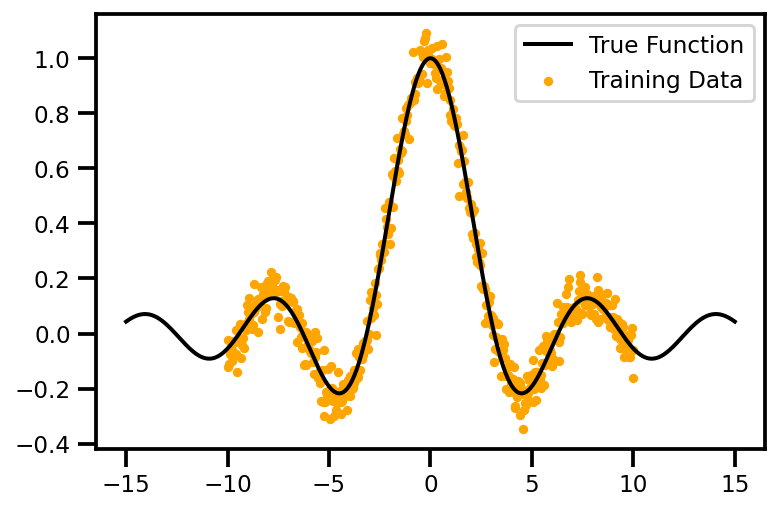

In [8]:
fig, ax = plt.subplots()

ax.scatter(xtrain, ytrain, s=10, color="orange", label="Training Data")
ax.plot(xtest, ytest, linewidth=2, color="black", label="True Function")

ax.legend()
plt.show()

### Plot Functions

In [9]:
def plot_results(ypred, stddevs=None):
    
    fig, ax = plt.subplots()
    
    ax.scatter(xtrain, ytrain, s=0.01, label='Training Points', color='blue')
    ax.plot(xtest, ypred, label='Predicted Points', color='red')
    ax.plot(xtrue, ytrue, label='Latent Function', color='black')
    if stddevs is not None:
        ax.fill_between(
            xtest.squeeze(), 
            (ypred - 2 * stddevs).squeeze(), 
            (ypred + 2 * stddevs).squeeze(),
            color='red', alpha=0.2,
            label='Confidence Interval', 
        )
    ax.legend()
    plt.show()
    
    
    return None

def plot_loss(history):
    
    # plot training history
    fig, ax = plt.subplots()
    ax.plot(history.history['loss'], label='train')
    plt.legend()
    plt.show()
    

### Linear Regression

This first case, we assume that there is no uncertainty in our model. We are just trying to function that maps our data from $\mathcal{X}$ to $\mathcal{Y}$.

$$f=wx+b$$

where:
* $w$ - regression weights
* $b$ - bias

$$\underset{w,b}{\text{min}} \frac{1}{2N}\sum_{i=1}^{N}
|| wx_i + b - y_i||_2^2 + 
\frac{\lambda}{2} \left( ||w||_2^2 + ||b||_2^2 \right)
$$

where:
* $\lambda$ - regularization coefficient to penalize large valued weights
* $l_2$ - reconstruction error (MSE)
* $l_2$ - regularization for the weights and bias
* $l_1$ - kernel regularization

In terms of the tensorflow 2.0 library, we have everything that we need to satisfy this objective function with the `tf.keras.layers.Dense` layer. It has all of the options to add the additional regularizations that we need for our objective functions.

```python
layer = tf.keras.layers.Dense(
    units=1,
    activation='softmax',
    kernel_regularization=None,
    bias_regularizer=tf.keras.regularizers.l2(0.01)
)
```

Epoch 1/100
8/8 [==============================] - 0s 3ms/step - loss: 2.5008 - mean_absolute_error: 1.4235
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 1.3174 - mean_absolute_error: 1.0436
Epoch 3/100
8/8 [==============================] - 0s 3ms/step - loss: 0.6008 - mean_absolute_error: 0.7038
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 0.2455 - mean_absolute_error: 0.4325
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 0.1389 - mean_absolute_error: 0.2955
Epoch 6/100
8/8 [==============================] - 0s 4ms/step - loss: 0.1293 - mean_absolute_error: 0.2781
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 0.1359 - mean_absolute_error: 0.2921
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 0.1350 - mean_absolute_error: 0.2909
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 0.1302 - mean_absolute_error: 0.2838
Epoch 10/100
8/8 [==========

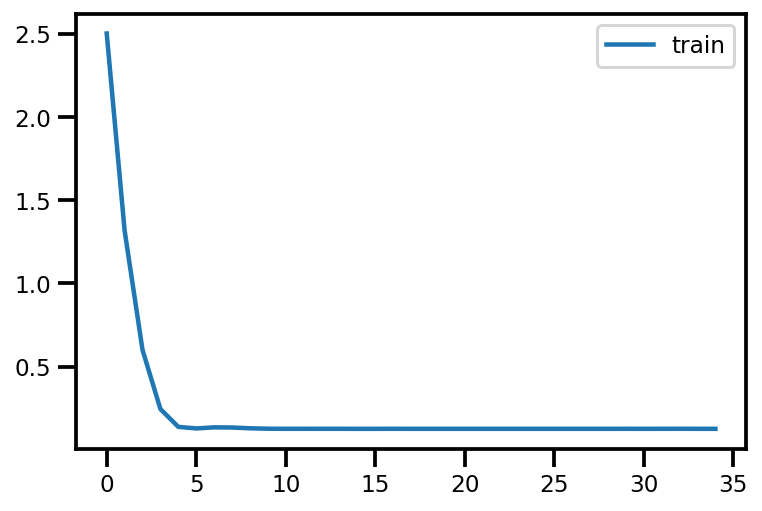

In [22]:
# initialize model
model = tf.keras.Sequential()

# single layer parameters
activation = tf.keras.activations.relu              # activation function
kernel_regularizer = tf.keras.regularizers.l2(0.01) # l2 regularization
bias_regularizer = tf.keras.regularizers.l2(0.01)   # l2 regularizer

# initialize model
model.add(
    tf.keras.layers.Dense(
        1,
        activation=None,
        kernel_regularizer=kernel_regularizer,
        bias_regularizer=bias_regularizer
    )
)

# configure model for mean-squared error regression
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = 'mean_squared_error'
metrics = ['mean_absolute_error']

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=20)

history = model.fit(xtrain, ytrain, epochs=100, verbose=1, callbacks=[es])

plot_loss(history)

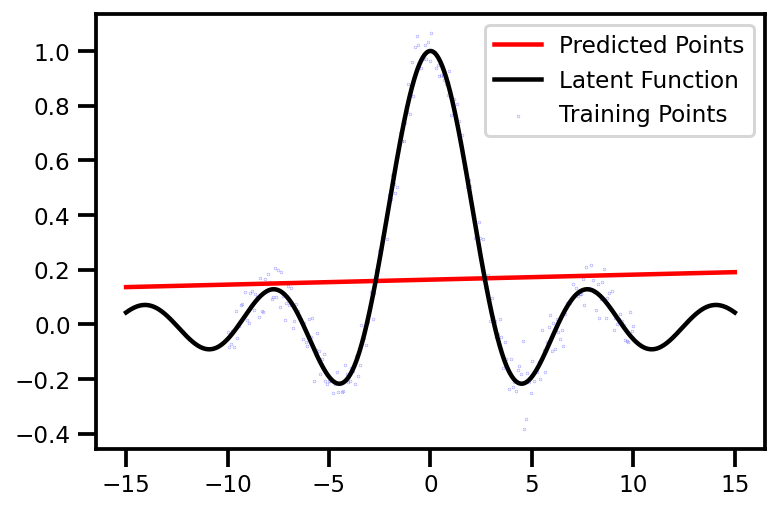

In [23]:
yhat = model.predict(xtest)

plot_results(yhat)


## Bayesian Linear Regression (Maximum Likelihood)

This will be very similar to the above linear regression formulation.

$$y_i \sim \mathcal{N}(wx_i, \sigma^2)$$
$$w \sim \mathcal{N}(0, \lambda^{-1})$$

$$w \sim \mathcal{N}(m, v)$$

First we need a log likelihood function.

In [24]:
def neg_log_likelihood(y, p_y):
    """Negative log likelihood loss function"""
    return -p_y.log_prob(y)

Now we want to define a normal distribution as the last layer of our neural network. We can use this special keras layer called the `DistributionLambda` which allows us to define a distribution that is conditioned on the layer inputs.

```python
noise = 0.01     # fixed noise parameter
layer = tfp.layers.DistributionLambda(lambda x: tfd.Normal(x, noise))
```

**Note**: we have to actually set the noise here. It would probably be much better if we actually learned the noise parameter. 


Epoch 1/100
8/8 [==============================] - 0s 3ms/step - loss: 1317.3788
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 435.8055
Epoch 3/100
8/8 [==============================] - 0s 3ms/step - loss: 69.9018
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 9.2511
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 27.1877
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 22.8518
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 8.9779
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 5.0881
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 6.0635
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 5.6853
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 5.0791
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 4.9924
Epoch 13/100
8/8 [==============================] - 0

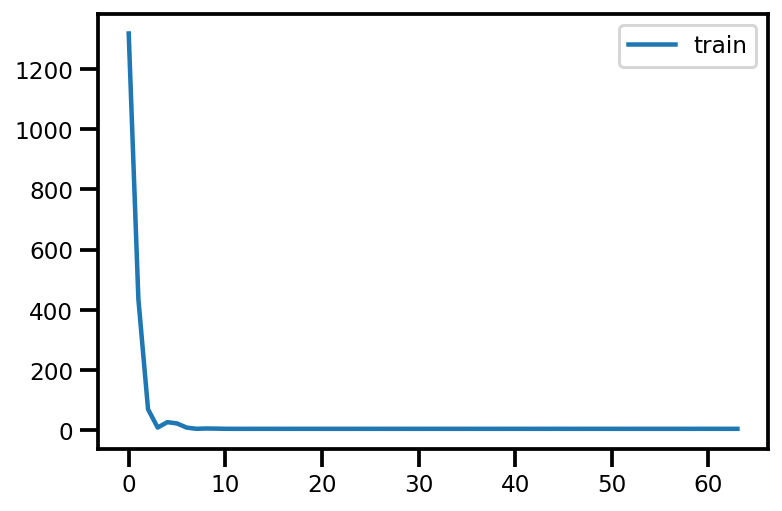

In [25]:
lambda_ = 100.
noise = ( 1 / lambda_) ** (1/2)  # weight std dev. prior

# build model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1),
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=noise))
])

# do inference
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss = neg_log_likelihood


model.compile(
    optimizer=optimizer,
    loss=neg_log_likelihood
)

es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=20)

history = model.fit(xtrain, ytrain, epochs=100, verbose=1, callbacks=[es])

plot_loss(history)

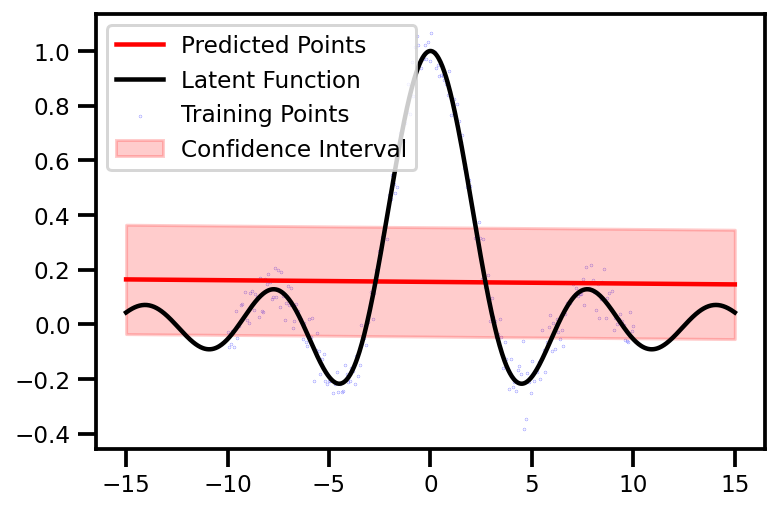

In [26]:
yhat = model(xtest)

plot_results(yhat.mean().numpy(), yhat.stddev().numpy())

#### Aleatoric Uncertainty

In this demonstration, I make an assumption that we can have uncertain w.r.t. to the inputs. This pivots off the note I mentioned earlier about being able to fit the noise as a function of the inputs. 

If we wanted to actually predict the noise coefficient of the normal distribution we could do something like this:

```python
noise = 0.05     # noise
jitter = 1e-3    # for stability reasons

layer = tfp.layers.DistributionLambda(
    lambda x: tfd.Normal(
        loc=x, 
        scale=1e-3 + tf.math.softplus(noise * t[..., 1:]))
)
```


But at the very least, we now have a neural network that gives us some uncertain estimates.

In [27]:
lambda_ = 100.
noise = ( 1 / lambda_) ** (1/2)  # weight std dev. prior

Epoch 1/100
8/8 [==============================] - 1s 3ms/step - loss: 73298.3281
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 4533.5747
Epoch 3/100
8/8 [==============================] - 0s 3ms/step - loss: 861.9164
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 361.4844
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 257.9195
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 208.2983
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 186.9795
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 174.5722
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 165.7518
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 158.7435
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 153.3272
Epoch 12/100
8/8 [==============================] - 0s 3ms/step - loss: 146.9155
Epoch 13/100
8/8 [================

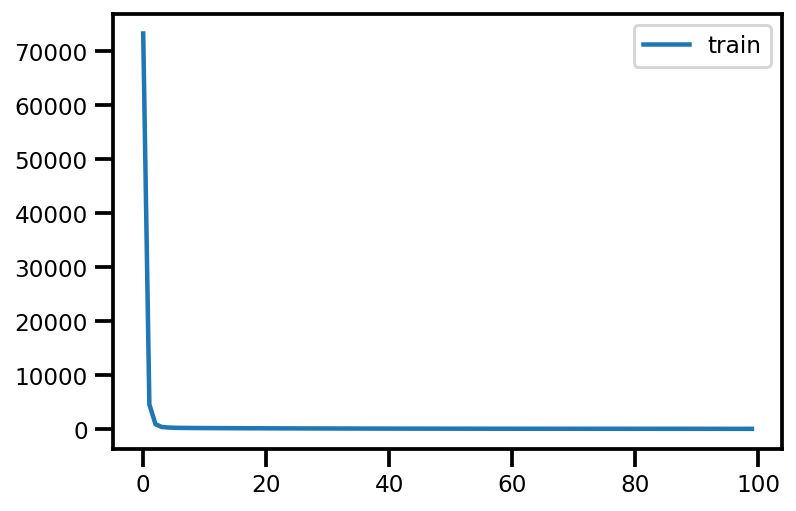

In [29]:
lambda_ = 100.
noise = .5 #( 1 / lambda_) ** (1/2)  # weight std dev. prior
jitter = 1e-3    # for stability reasons

# build model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1 + 1),
    tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(
            loc=t[..., :1], 
            scale=jitter + tf.math.softplus(noise * t[..., 1:]))
    )
])

# do inference
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss = neg_log_likelihood


model.compile(
    optimizer=optimizer,
    loss=neg_log_likelihood
)

es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=20)

history = model.fit(xtrain, ytrain, epochs=100, verbose=1, callbacks=[es])

plot_loss(history)

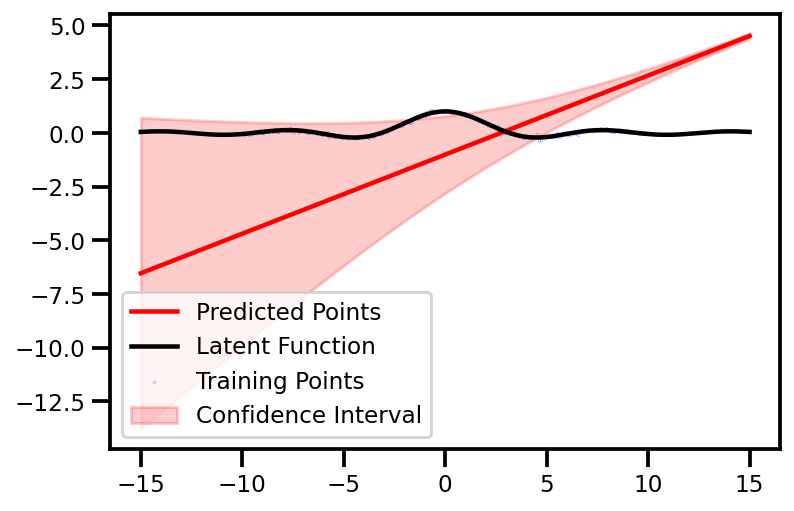

In [30]:
yhat = model(xtest)

plot_results(yhat.mean().numpy(), yhat.stddev().numpy())

As you can see, our error bars change w.r.t. to the inputs.

### Bayesian Linear Regression (Variational)

In this example, we will be looking at how we can extend the Bayesian LR method with variational features. From an uncvertainty perspective, we are looking at 


Again, this will be very similar to the above linear regression formulation.

$$y_i \sim \mathcal{N}(wx_i, \sigma^2)$$
$$w \sim \mathcal{N}(0, \lambda^{-1})$$

We want to estimate the parameters of the posterior distribution over the weights.

$$w \sim \mathcal{N}(m, v)$$

We can use the evidence lower bound (ELBO) which we can easily use with stochastic gradient descent (SGD) methods which also allows us to train in batches. For Bayesian linear regression, we have it of the form:

$$\underset{m,\nu, \sigma}{\text{min}}-\sigma_{i=1}^N
\mathbb{E}_{\mathcal{N}(w|m,\nu)}
\left[\log \mathcal{N}(y_i | wx_i, \sigma^2) \right] + 
\text{KL}\left[ \mathcal{N}(w|m, \nu) || \mathcal{N}(w| 0, \lambda^{-1}) \right]
$$

We can use the `tf.keras.layers.DenseVariational` in order to define our distribution. 


In addition, we can define some prior distributions for our variational parameters.

```python
dtype = ...
kernel_size = ...
bias_size = ...
n = kernel_size + bias_size

# define prior
priors = tf.keras.Sequential([
    tfp.layers.VariableLayer(n, dtype=dtype),
    tfp.layers.DistributionLambda(lambda t: tfd.Independent(
        tfd.Normal(loc=t, scale=1),
        reinterpreted_batch_ndims=1
    ))
])
```

#### Variational Distribution Poster

We will use one of the simplest: the mean field. This will give us a surrogate (pyro guide) distribution to learn for our layer with the weights and bias.



In [ ]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
    ])

#### Prior Distribution

We also need to find the prior distribution to put over our layer with the weights and bias terms.

In [ ]:
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
    ])

Train on 1000 samples
Epoch 1/500
1000/1000 [==============================] - 1s 881us/sample - loss: 1051.8567
Epoch 2/500
1000/1000 [==============================] - 0s 121us/sample - loss: 310.4524
Epoch 3/500
1000/1000 [==============================] - 0s 120us/sample - loss: 176.5165
Epoch 4/500
1000/1000 [==============================] - 0s 125us/sample - loss: 149.0721
Epoch 5/500
1000/1000 [==============================] - 0s 116us/sample - loss: 81.2045
Epoch 6/500
1000/1000 [==============================] - 0s 115us/sample - loss: 54.7781
Epoch 7/500
1000/1000 [==============================] - 0s 126us/sample - loss: 42.9768
Epoch 8/500
1000/1000 [==============================] - 0s 124us/sample - loss: 34.1406
Epoch 9/500
1000/1000 [==============================] - 0s 121us/sample - loss: 50.0728
Epoch 10/500
1000/1000 [==============================] - 0s 121us/sample - loss: 18.7812
Epoch 11/500
1000/1000 [==============================] - 0s 118us/sample - loss: 

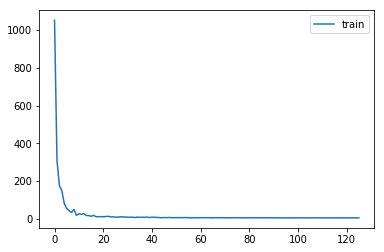

In [ ]:
# model parameters
lambda_ = 100.
noise = ( 1 / lambda_) ** (1/2)  # weight std dev. prior
n_samples = xtrain.shape[0]


# build model
model = tf.keras.Sequential([
    # Variational Layer
    tfp.layers.DenseVariational(
        1,
        posterior_mean_field,
        prior_trainable,
        kl_weight=1/n_samples,
    ),
    # Normal Distribution Output
    tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(
            loc=t, 
            scale=noise
        )
    )
])

# do inference
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss = neg_log_likelihood


model.compile(
    optimizer=optimizer,
    loss=neg_log_likelihood
)

es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=20)

history = model.fit(xtrain, ytrain, epochs=500, verbose=1, callbacks=[es])

plot_loss(history)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



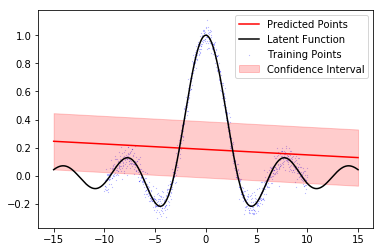

In [ ]:
yhat = model(xtest)

plot_results(yhat.mean().numpy(), yhat.stddev().numpy())

## Neural Network

We will do a classic neural network scenario.


$$f=\text{NN}(x)$$

The NN refers to as a composition of functions.

$$\underset{w,b}{\text{min}} \frac{1}{2N}\sum_{i=1}^{N}
|| \text{NN}(x_i) + b - y_i||_2^2 + 
\sum_{l=1}^{L}\frac{\lambda_l}{2} \left( ||w_l||_2^2 + ||b_l||_2^2 \right)
$$

where:
* $\lambda$ - regularization coefficient to penalize large valued weights
* $l_2$ - reconstruction error (MSE)
* $l_2$ - regularization for the weights and bias
* $l_1$ - kernel regularization

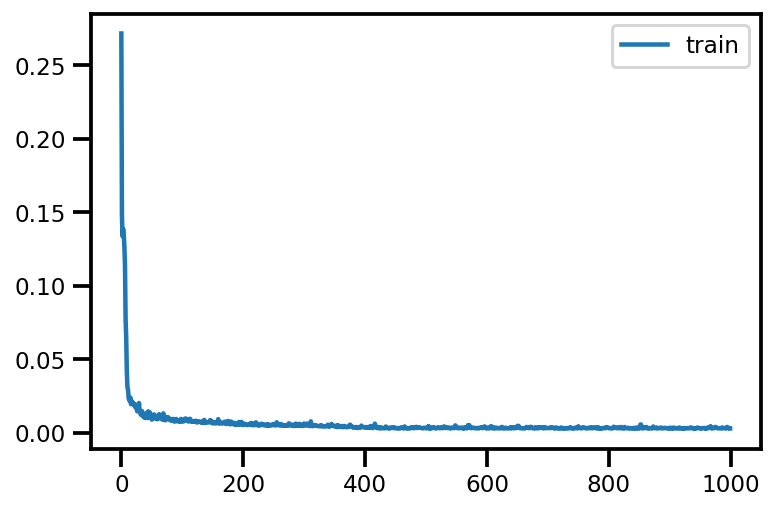

In [10]:
# single layer parameters
lambda_ = 1e-5
activation = tf.keras.activations.sigmoid                 # activation function
kernel_regularizer = None # tf.keras.regularizers.l2(lambda_) # l2 regularization
bias_regularizer = None # tf.keras.regularizers.l2(lambda_)   # l2 regularizer


# build model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(
        64, activation,
        kernel_regularizer=kernel_regularizer,
        bias_regularizer=bias_regularizer,
    ),
    tf.keras.layers.Dense(
        64, activation,
        kernel_regularizer=kernel_regularizer,
        bias_regularizer=bias_regularizer,
    ),
    tf.keras.layers.Dense(
        1,
        kernel_regularizer=kernel_regularizer,
        bias_regularizer=bias_regularizer,
    ),
])

# do inference
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = 'mean_squared_error'


model.compile(
    optimizer=optimizer,
    loss=loss
)

es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=20)

history = model.fit(xtrain, ytrain, batch_size=32, epochs=1_000, verbose=2)


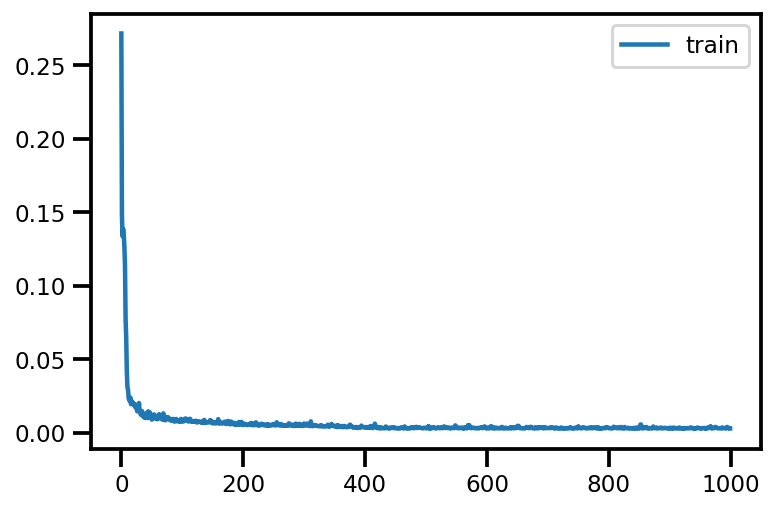

In [11]:
plot_loss(history)

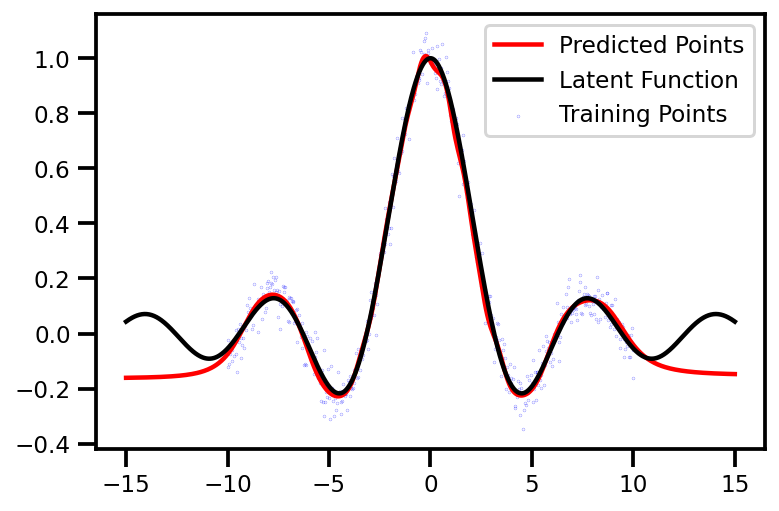

In [12]:
yhat = model.predict(xtest)

plot_results(yhat)

## Probabilistic Neural Network

So we will have the same NN architecture as above except this time we will add a Gaussian distribution as the last layer of the NN.

In [18]:
# single layer parameters
lambda_ = 1e-4
activation = tf.keras.activations.sigmoid                 # activation function
w_reg = None # tf.keras.regularizers.l2(lambda_) # l2 regularization
b_reg = None # tf.keras.regularizers.l2(lambda_)   # l2 regularizer

# final prob layer parameters
noise = 0.1        # likelihood stddev


# build model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(
        64, activation,
        kernel_regularizer=w_reg,
        bias_regularizer=b_reg,
    ),
    tf.keras.layers.Dense(
        64, activation,
        kernel_regularizer=w_reg,
        bias_regularizer=b_reg,
    ),
    tf.keras.layers.Dense(
        1, None,
        kernel_regularizer=w_reg,
        bias_regularizer=b_reg,
    ),
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=noise))
])

# do inference
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
def neg_log_likelihood(y, p_y):
    """Negative log likelihood loss function"""
    return -p_y.log_prob(y)
    
loss = neg_log_likelihood


model.compile(
    optimizer=optimizer,
    loss=neg_log_likelihood
)

# es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=20)

history = model.fit(xtrain, ytrain, batch_size=32, epochs=1_000, verbose=None, callbacks=None)

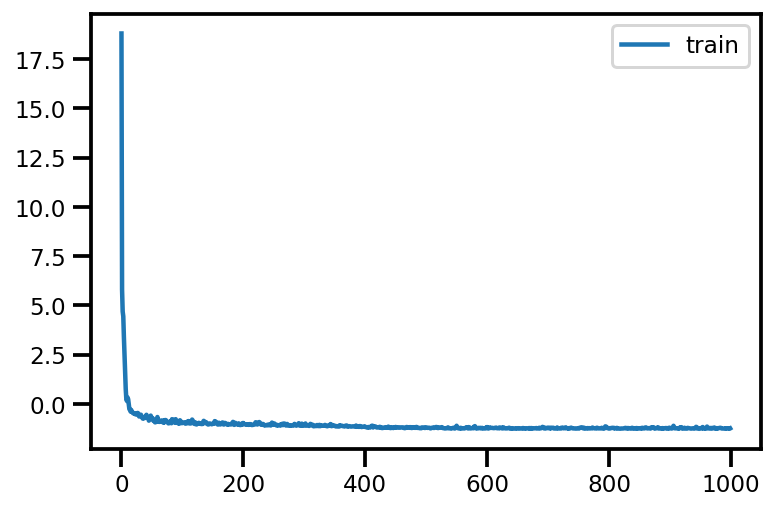

In [19]:
plot_loss(history)

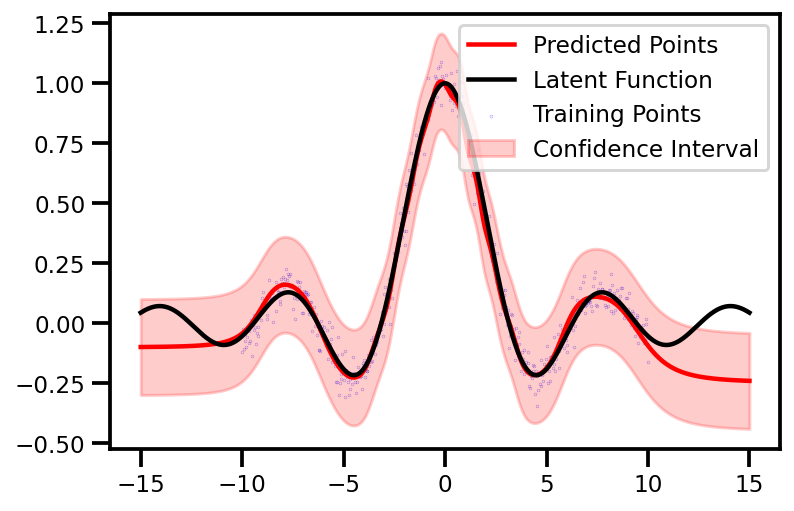

In [20]:
yhat = model(xtest)

plot_results(yhat.mean().numpy(), yhat.stddev().numpy())

## Probabilistic Neural Network (Heteroscedasstic)

In [24]:
# dense layer parameters
lambda_ = None
activation = tf.keras.activations.sigmoid                 # activation function
w_reg = None # tf.keras.regularizers.l2(lambda_) # l2 regularization
b_reg = None # tf.keras.regularizers.l2(lambda_)   # l2 regularizer

# dropout layer fixed params
seed = 1
jitter = 1e-5

# final prob layer parameters
noise = 0.1        # likelihood stddev


# build model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(
        64, activation,
        kernel_regularizer=kernel_regularizer,
        bias_regularizer=bias_regularizer,
    ),
    tf.keras.layers.Dense(
        64, activation,
        kernel_regularizer=kernel_regularizer,
        bias_regularizer=bias_regularizer,
    ),
    tf.keras.layers.Dense(
        2, None,
        kernel_regularizer=kernel_regularizer,
        bias_regularizer=bias_regularizer,
    ),
    tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(
            loc=t[..., :1], 
            scale=jitter + tf.math.softplus(noise * t[..., 1:]))
    )
])

# do inference
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = neg_log_likelihood


model.compile(
    optimizer=optimizer,
    loss=neg_log_likelihood
)

es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=50)

history = model.fit(xtrain, ytrain, batch_size=32, epochs=1_500, verbose=False, callbacks=None)


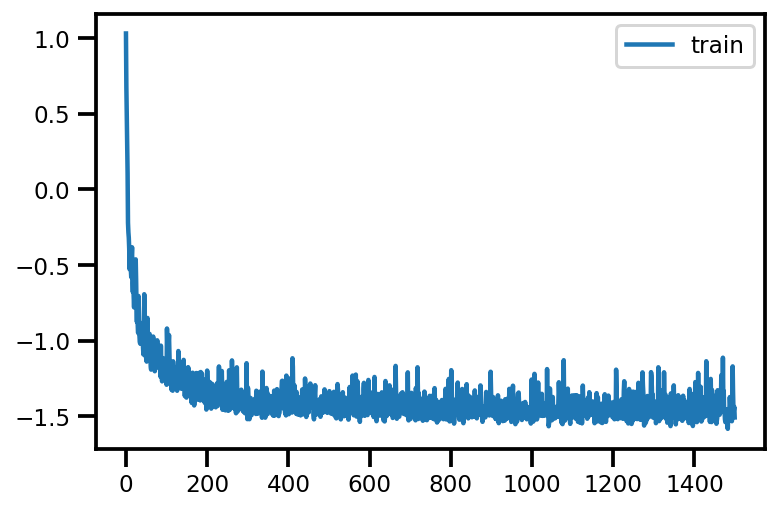

In [25]:
plot_loss(history)

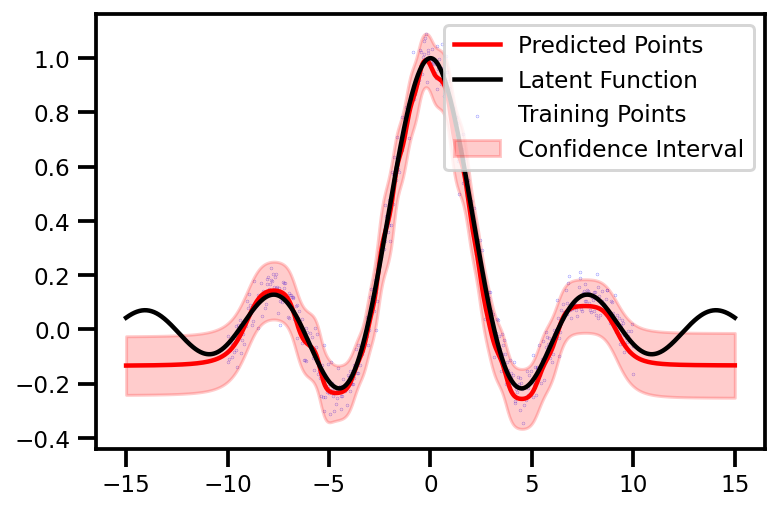

In [26]:
yhat = model(xtest)

plot_results(yhat.mean().numpy(), yhat.stddev().numpy())

## Bayesian Neural Network (Drop-Out)

One nice trick to using a normal NN to train

In [55]:
# dense layer parameters
lambda_ = None
activation = tf.keras.activations.sigmoid                 # activation function
w_reg = None # tf.keras.regularizers.l2(lambda_) # l2 regularization
b_reg = None # tf.keras.regularizers.l2(lambda_)   # l2 regularizer

# dropout layer fixed params
seed = 1

# final prob layer parameters
noise = 0.1        # likelihood stddev


# build model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(
        64, activation,
        kernel_regularizer=kernel_regularizer,
        bias_regularizer=bias_regularizer,
    ),
    tf.keras.layers.Dropout(0.1, seed=seed),
    tf.keras.layers.Dense(
        64, activation,
        kernel_regularizer=kernel_regularizer,
        bias_regularizer=bias_regularizer,
    ),
    tf.keras.layers.Dropout(0.1, seed=seed),
    tf.keras.layers.Dense(
        1, None,
        kernel_regularizer=kernel_regularizer,
        bias_regularizer=bias_regularizer,
    ),
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=noise))
])

# do inference
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = neg_log_likelihood


model.compile(
    optimizer=optimizer,
    loss=neg_log_likelihood
)

es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=50)

history = model.fit(xtrain, ytrain, batch_size=32, epochs=1_500, verbose=False, callbacks=None)




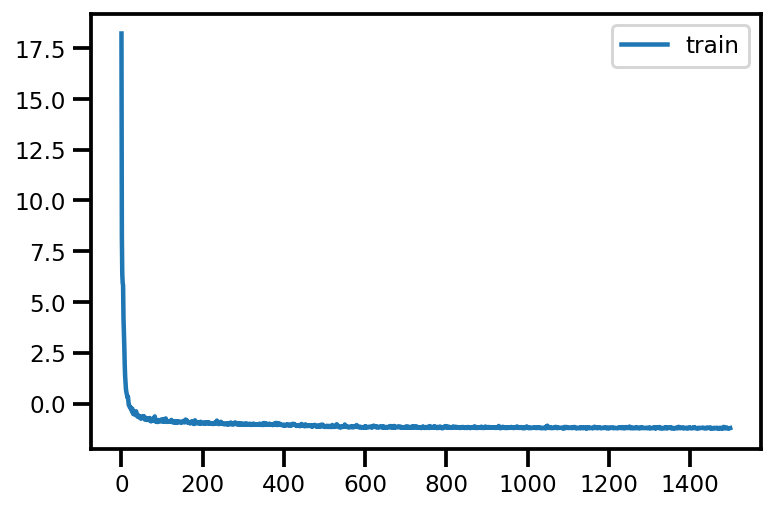

In [56]:
plot_loss(history)

In [57]:
yhat.shape

(500, 100)

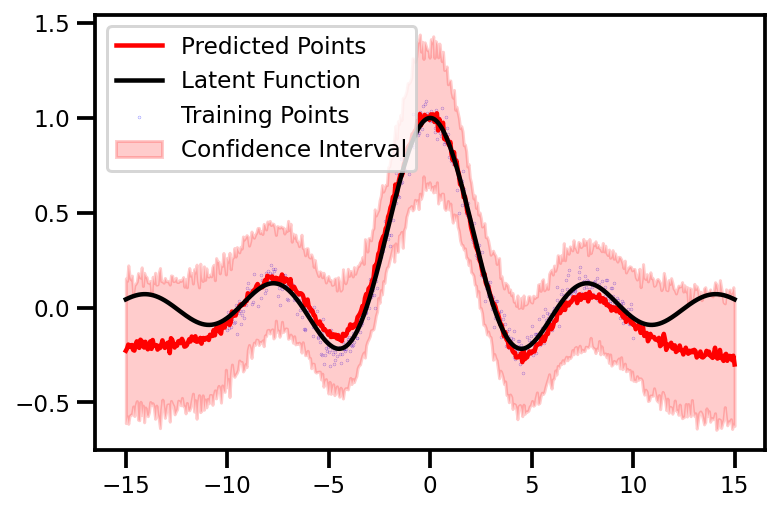

In [58]:
n_test_samples = 100

yhat = [model(xtest, training=True) for _ in range(n_test_samples)]
yhat = tf.concat(yhat, axis=1).numpy()
y_mu = yhat.mean(axis=1)
y_std = yhat.std(axis=1)

plot_results(y_mu, y_std)

## Probabilisitc NN (Dropout - Heteroscedastic)

In [137]:
# dense layer parameters
lambda_ = None
activation = tf.keras.activations.sigmoid                 # activation function
w_reg = None # tf.keras.regularizers.l2(lambda_) # l2 regularization
b_reg = None # tf.keras.regularizers.l2(lambda_)   # l2 regularizer

# dropout layer fixed params
seed = 1
jitter = 1e-5

# final prob layer parameters
noise = 0.1        # likelihood stddev


# build model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(
        64, activation,
        kernel_regularizer=kernel_regularizer,
        bias_regularizer=bias_regularizer,
    ),
    tf.keras.layers.Dropout(0.1, seed=seed),
    tf.keras.layers.Dense(
        64, activation,
        kernel_regularizer=kernel_regularizer,
        bias_regularizer=bias_regularizer,
    ),
    tf.keras.layers.Dropout(0.1, seed=seed),
    tf.keras.layers.Dense(
        2, None,
        kernel_regularizer=kernel_regularizer,
        bias_regularizer=bias_regularizer,
    ),
    tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(
            loc=t[..., :1], 
            scale=jitter + tf.math.softplus(noise * t[..., 1:]))
    )
])

# do inference
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = neg_log_likelihood


model.compile(
    optimizer=optimizer,
    loss=neg_log_likelihood
)

es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=50)

history = model.fit(xtrain, ytrain, batch_size=32, epochs=2_000, verbose=False, callbacks=None)



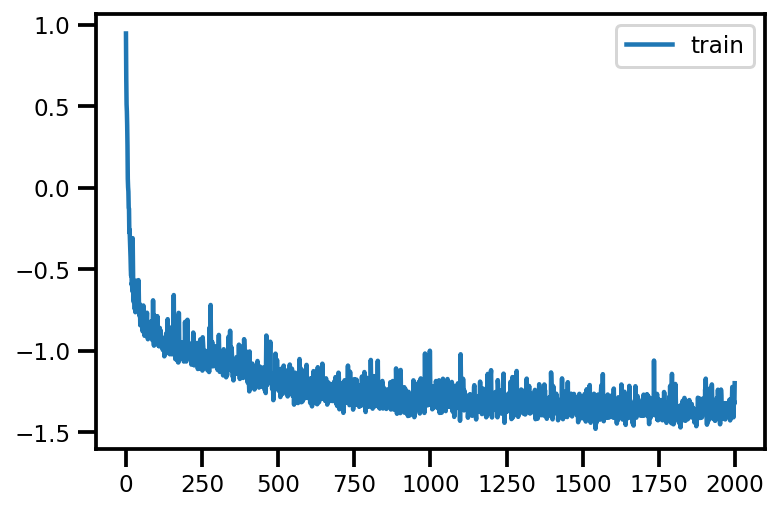

In [138]:
plot_loss(history)

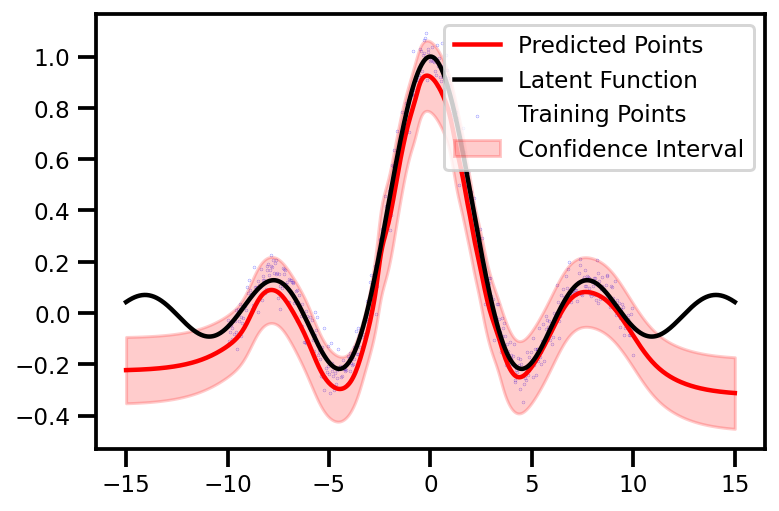

In [141]:
yhat = model(xtest, training=False)

plot_results(yhat.mean().numpy(), yhat.stddev().numpy())

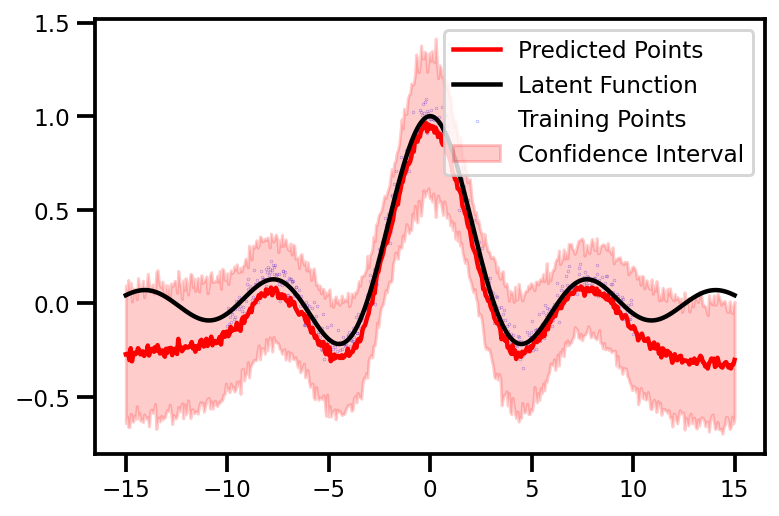

In [142]:
n_test_samples = 100

yhat = [model(xtest, training=True) for _ in range(n_test_samples)]
yhat = tf.concat(yhat, axis=1).numpy()
y_mu = yhat.mean(axis=1)
y_std = yhat.std(axis=1)

plot_results(y_mu, y_std)

## Bayesian Neural Network (Vanilla)

In [95]:
# # Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
# def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
#   n = kernel_size + bias_size
#   c = np.log(np.expm1(1.))
#   return tf.keras.Sequential([
#       tfp.layers.VariableLayer(2 * n, dtype=dtype),
#       tfp.layers.DistributionLambda(lambda t: tfd.Independent(
#           tfd.Normal(loc=t[..., :n],
#                      scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
#           reinterpreted_batch_ndims=1)),
#   ])

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = tf.keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

In [96]:
# # Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
# def prior_trainable(kernel_size, bias_size=0, dtype=None):
#   n = kernel_size + bias_size
#   return tf.keras.Sequential([
#       tfp.layers.VariableLayer(n, dtype=dtype),
#       tfp.layers.DistributionLambda(lambda t: tfd.Independent(
#           tfd.Normal(loc=t, scale=1),
#           reinterpreted_batch_ndims=1)),
#   ])

def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = tf.keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model

In [101]:
# model parameters
tf.keras.backend.set_floatx('float32')

lambda_ = 100.
noise = ( 1 / lambda_) ** (1/2)  # weight std dev. prior
n_samples = xtrain.shape[0]


# build model
model = tf.keras.Sequential([
    # Variational Layer
    tfp.layers.DenseVariational(
        32,
        posterior,
        prior,
        kl_weight=1/n_samples,
        activation='sigmoid'
    ),
    tfp.layers.DenseVariational(
        32,
        posterior,
        prior,
        kl_weight=1/n_samples,
        activation='sigmoid'
    ),
    tf.keras.layers.Dense(
        1, None,
        kernel_regularizer=kernel_regularizer,
        bias_regularizer=bias_regularizer,
    ),
    # Normal Distribution Output
    tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(
            loc=t, 
            scale=noise
        )
    )
])

# do inference
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = neg_log_likelihood


model.compile(
    optimizer=optimizer,
    loss=neg_log_likelihood
)


history = model.fit(xtrain, ytrain, batch_size=32, epochs=1_000, verbose=False, callbacks=None)

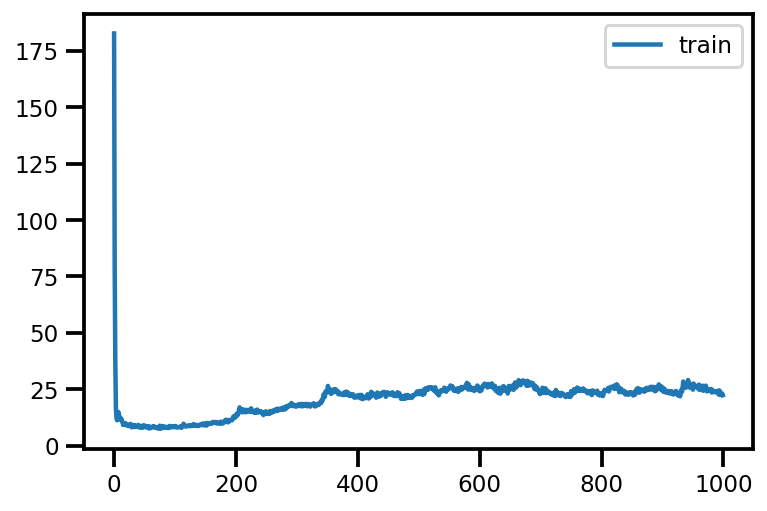

In [102]:
plot_loss(history)

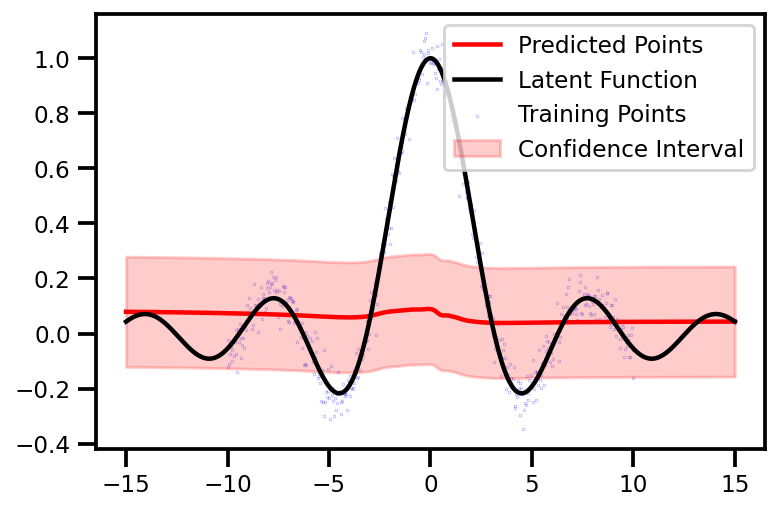

In [103]:
yhat = model(xtest)

plot_results(yhat.mean().numpy(), yhat.stddev().numpy())

In [82]:
n_test_samples = 100

yhat = [model(xtest, training=True) for _ in range(n_test_samples)]
yhat = tf.concat(yhat, axis=1).numpy()
y_mu = yhat.mean(axis=1)
y_std = yhat.std(axis=1)

plot_results(y_mu, y_std)

ResourceExhaustedError: ignored

## Support Vector Regression (RFF Approximations)

In [108]:
from tensorflow.keras.layers.experimental import RandomFourierFeatures

In [116]:
tf.keras.backend.set_floatx('float32')
# initialize model
model = tf.keras.Sequential()

# single layer parameters
activation = tf.keras.activations.sigmoid           # activation function
kernel_regularizer = None # tf.keras.regularizers.l2(0.01) # l2 regularization
bias_regularizer = None # tf.keras.regularizers.l2(0.01)   # l2 regularizer

n_features = 20
kernel = 'gaussian'
scale=None # 0.1
trainable = True
# initialize model
model = tf.keras.Sequential([
    RandomFourierFeatures(        
        output_dim=n_features,
        kernel_initializer=tf.initializers.RandomNormal(),
        scale=scale,
        trainable=trainable,
        name='rff'
    ),
    tf.keras.layers.Dense(
        1,
        activation=None,
        kernel_regularizer=kernel_regularizer,
        bias_regularizer=bias_regularizer,
    )
])

# configure model for mean-squared error regression
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = 'mean_squared_error'
metrics = ['mean_absolute_error']

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

history = model.fit(xtrain, ytrain, batch_size=32, epochs=1_000, verbose=False, callbacks=None)


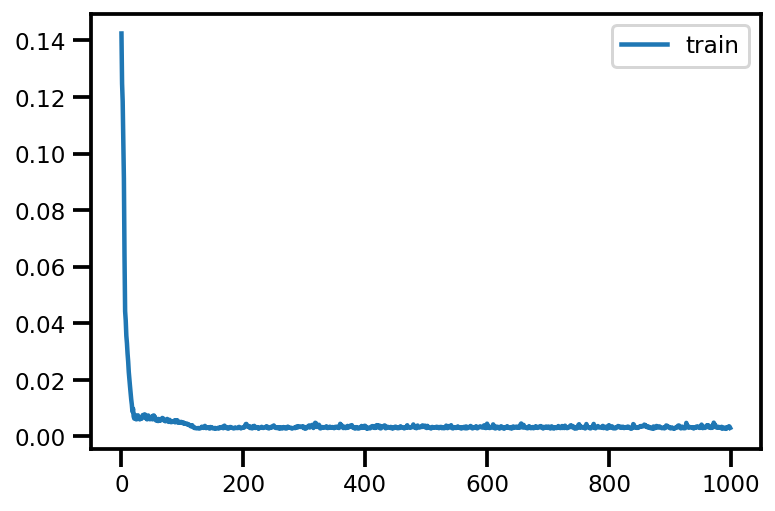

In [117]:
plot_loss(history)

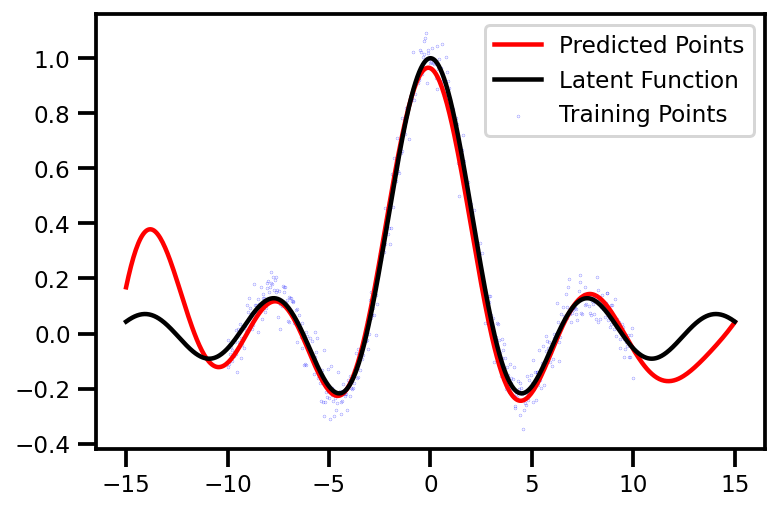

In [118]:
yhat = model(xtest)

plot_results(yhat.numpy())

In [121]:
tf.keras.backend.set_floatx('float32')
# initialize model
model = tf.keras.Sequential()

# single layer parameters
activation = tf.keras.activations.sigmoid           # activation function
kernel_regularizer = None # tf.keras.regularizers.l2(0.01) # l2 regularization
bias_regularizer = None # tf.keras.regularizers.l2(0.01)   # l2 regularizer

n_features = 20
kernel = 'gaussian'
scale=None # 0.1
trainable = True
# initialize model
model = tf.keras.Sequential([
    RandomFourierFeatures(        
        output_dim=n_features,
        kernel_initializer=tf.initializers.RandomNormal(),
        scale=scale,
        trainable=trainable,
        name='rffl0'
    ),
    tf.keras.layers.Dense(
        64,
        activation=activation,
        kernel_regularizer=kernel_regularizer,
        bias_regularizer=bias_regularizer,
    ),
    RandomFourierFeatures(        
        output_dim=n_features,
        kernel_initializer=tf.initializers.RandomNormal(),
        scale=scale,
        trainable=trainable,
        name='rffl1'
    ),
    tf.keras.layers.Dense(
        64,
        activation=activation,
        kernel_regularizer=kernel_regularizer,
        bias_regularizer=bias_regularizer,
    ),
    RandomFourierFeatures(        
        output_dim=n_features,
        kernel_initializer=tf.initializers.RandomNormal(),
        scale=scale,
        trainable=trainable,
        name='rffl2'
    ),
    tf.keras.layers.Dense(
        1,
        activation=None,
        kernel_regularizer=kernel_regularizer,
        bias_regularizer=bias_regularizer,
    )
])

# configure model for mean-squared error regression
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = 'mean_squared_error'
metrics = ['mean_absolute_error']

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

history = model.fit(xtrain, ytrain, batch_size=32, epochs=1_000, verbose=False, callbacks=None)


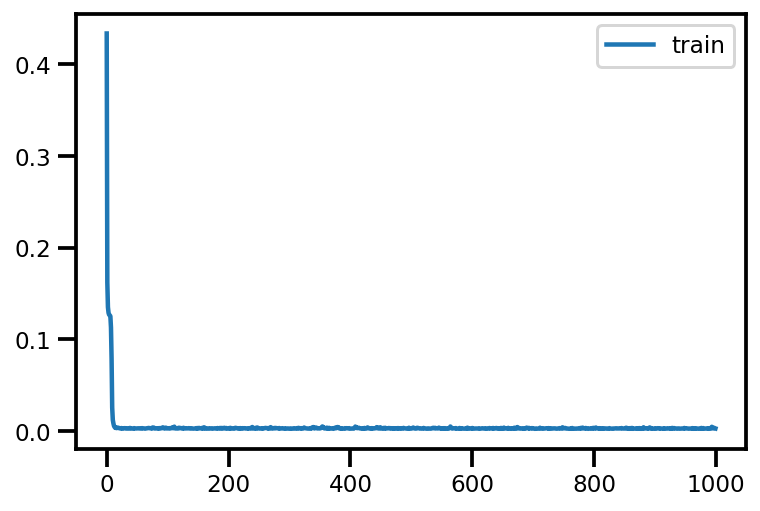

In [122]:
plot_loss(history)

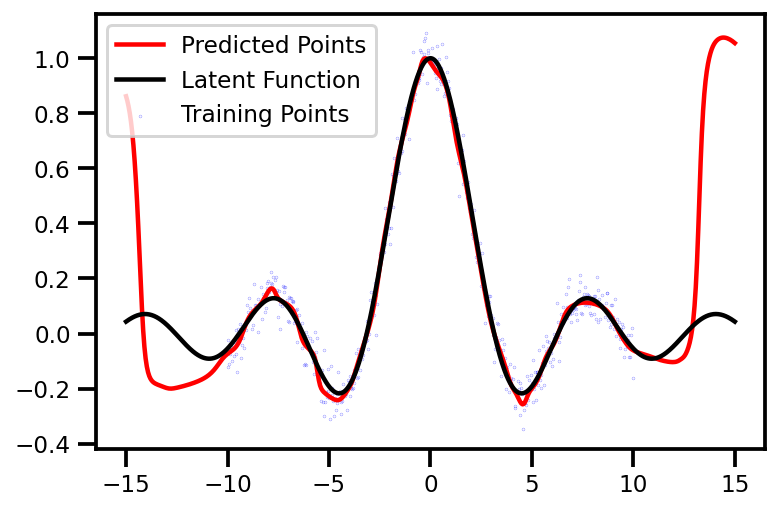

In [123]:
yhat = model(xtest)

plot_results(yhat.numpy())

## SVR (Deep)

In [127]:
tf.keras.backend.set_floatx('float32')
# initialize model
model = tf.keras.Sequential()

# single layer parameters
activation = tf.keras.activations.sigmoid           # activation function
kernel_regularizer = None # tf.keras.regularizers.l2(0.01) # l2 regularization
bias_regularizer = None # tf.keras.regularizers.l2(0.01)   # l2 regularizer

n_features = 32
kernel = 'gaussian'
scale=None # 0.1
trainable = True
# initialize model
model = tf.keras.Sequential([
    RandomFourierFeatures(        
        output_dim=n_features,
        kernel_initializer=tf.initializers.RandomNormal(),
        scale=scale,
        trainable=trainable,
        name='rff_l1'
    ),
    tf.keras.layers.Dense(
        16,
        activation=activation,
        kernel_regularizer=kernel_regularizer,
        bias_regularizer=bias_regularizer,
    ),
    RandomFourierFeatures(        
        output_dim=n_features,
        kernel_initializer=tf.initializers.RandomNormal(),
        scale=scale,
        trainable=trainable,
        name='rff_l2'
    ),
    tf.keras.layers.Dense(
        2, None,
        kernel_regularizer=kernel_regularizer,
        bias_regularizer=bias_regularizer,
    ),
    tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(
            loc=t[..., :1], 
            scale=jitter + tf.math.softplus(noise * t[..., 1:]))
    )
])

# do inference
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = neg_log_likelihood


model.compile(
    optimizer=optimizer,
    loss=neg_log_likelihood
)

es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=50)

history = model.fit(xtrain, ytrain, batch_size=32, epochs=1_500, verbose=False, callbacks=None)

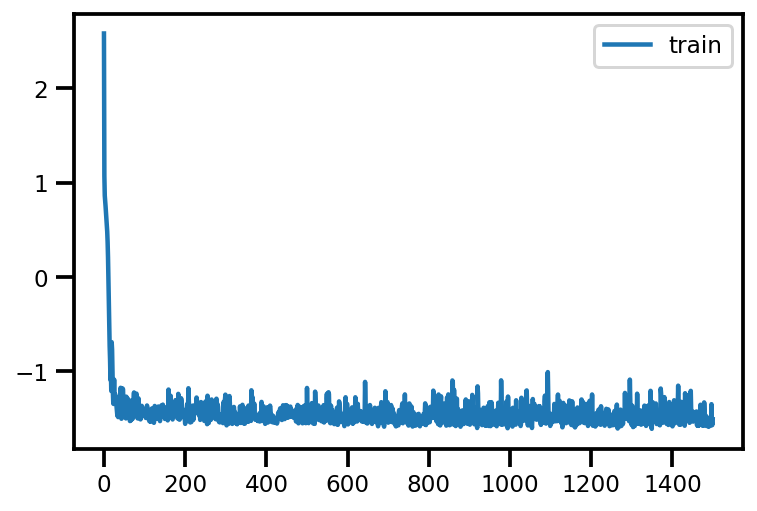

In [128]:
plot_loss(history)

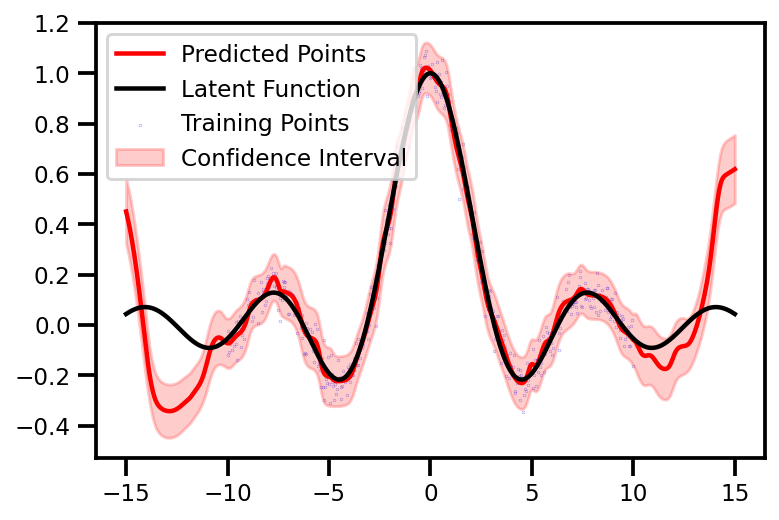

In [136]:
yhat = model(xtest)


plot_results(yhat.mean().numpy(), yhat.stddev().numpy())

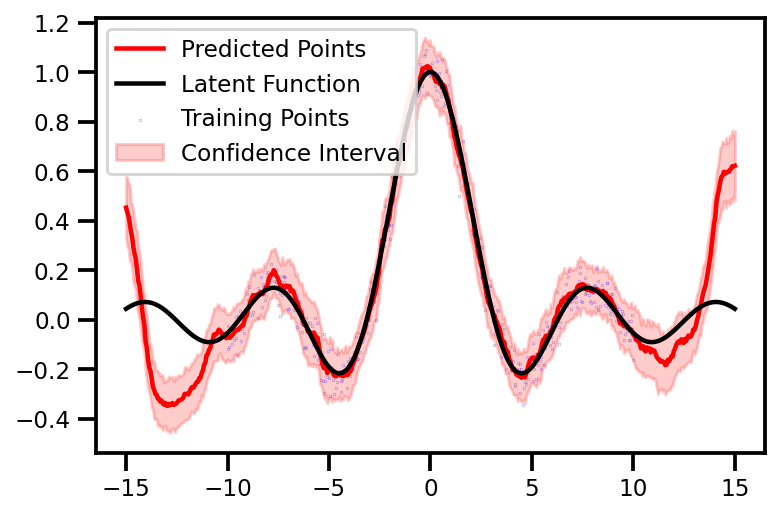

In [130]:
n_test_samples = 100

yhat = [model(xtest, training=True) for _ in range(n_test_samples)]
yhat = tf.concat(yhat, axis=1).numpy()
y_mu = yhat.mean(axis=1)
y_std = yhat.std(axis=1)

plot_results(y_mu, y_std)

## Gaussian Processes (RFF Approx.)

In [171]:
# For numeric stability, set the default floating-point dtype to float64
tf.keras.backend.set_floatx('float32')

# model parameters
lambda_ = 100.
noise = ( 1 / lambda_) ** (1/2)  # weight std dev. prior
n_samples = xtrain.shape[0]


n_features = 16
scale = None # tf.Variable(.5)
kernel_initializer = 'gaussian'
trainable = True
# initialize model
model = tf.keras.Sequential([
    # RFF Layer
    RandomFourierFeatures(        
        output_dim=n_features,
        kernel_initializer=kernel_initializer,
        scale =scale,
        trainable=trainable,
        name='rff'
    ),
    # Variational Layer
    tfp.layers.DenseVariational(
        1,
        posterior,
        prior,
        kl_weight=1/n_samples,
    ),
    # Normal Distribution Output
    tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(
            loc=t, 
            scale=noise
        )
    )
])

# do inference
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)


loss = lambda y, rv_y: rv_y.variational_loss(
    y, kl_weight=np.array(xtrain.shape[0], x.dtype) / x.shape[0])


model.compile(
    optimizer=optimizer,
    loss=neg_log_likelihood
)

es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=None)

history = model.fit(xtrain, ytrain, batch_size=32, epochs=1_500, verbose=None, callbacks=None)

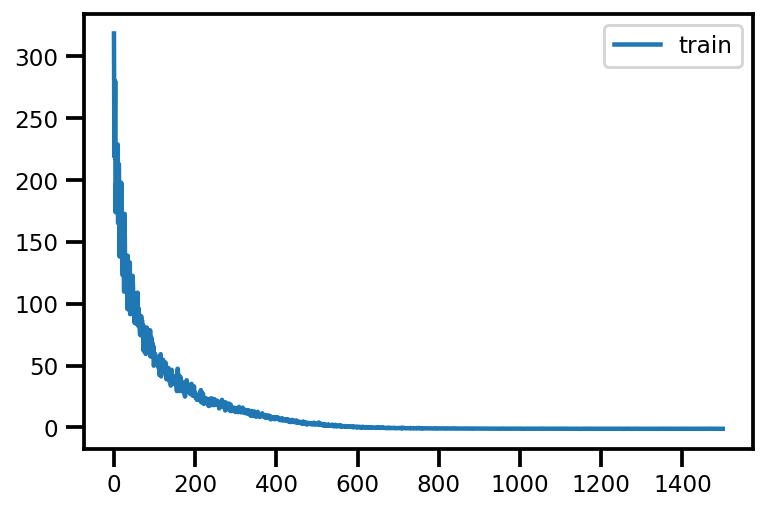

In [172]:
plot_loss(history)

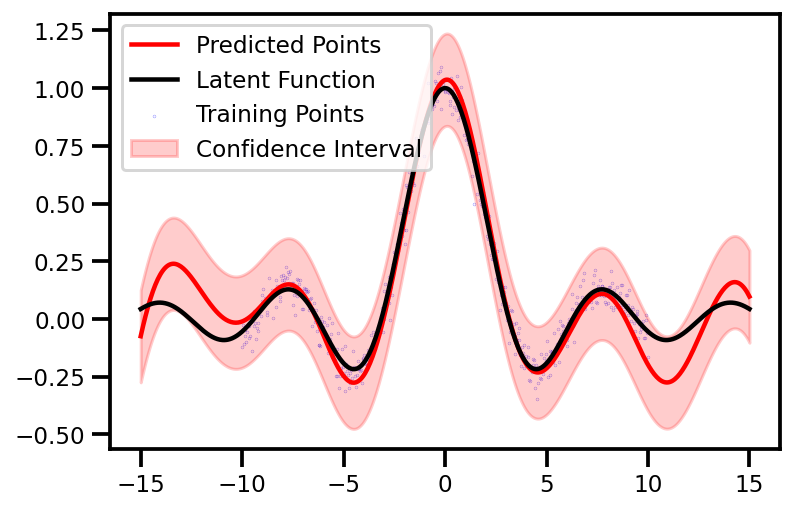

In [173]:
yhat = model(xtest)

plot_results(yhat.mean().numpy(), yhat.stddev().numpy())

### Heteroscedastic

In [180]:
# For numeric stability, set the default floating-point dtype to float64
tf.keras.backend.set_floatx('float32')

# model parameters
lambda_ = 1000.
noise = ( 1 / lambda_) ** (1/2)  # weight std dev. prior
n_samples = xtrain.shape[0]


n_features = 16
scale = None # tf.Variable(.5)
kernel_initializer = 'gaussian'
trainable = True
# initialize model
model = tf.keras.Sequential([
    # RFF Layer
    RandomFourierFeatures(        
        output_dim=n_features,
        kernel_initializer=kernel_initializer,
        scale =scale,
        trainable=trainable,
        name='rff'
    ),
    # Variational Layer
    tfp.layers.DenseVariational(
        2,
        posterior,
        prior,
        kl_weight=1/n_samples,
    ),
    # Normal Distribution Output
    tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(
            loc=t[..., :1], 
            scale=jitter + tf.math.softplus(noise * t[..., 1:]))
    )
])

# do inference
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)


loss = lambda y, rv_y: rv_y.variational_loss(
    y, kl_weight=np.array(xtrain.shape[0], x.dtype) / x.shape[0])


model.compile(
    optimizer=optimizer,
    loss=neg_log_likelihood
)

es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=30)

history = model.fit(xtrain, ytrain, batch_size=32, epochs=2_000, verbose=None, callbacks=None)

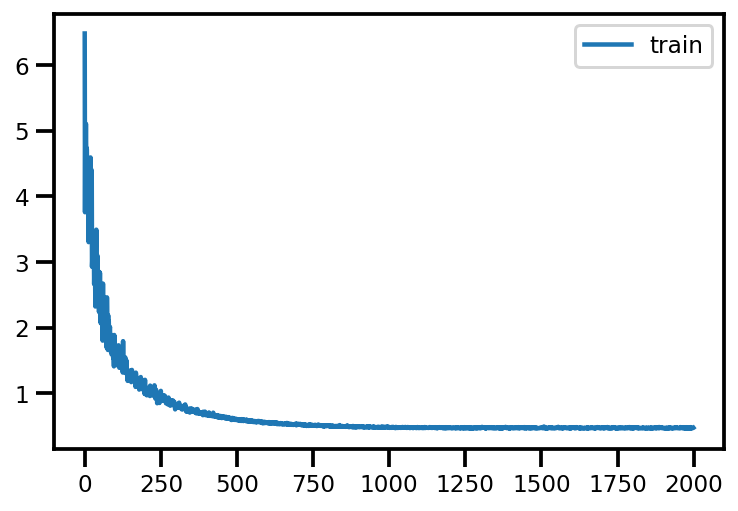

In [181]:
plot_loss(history)

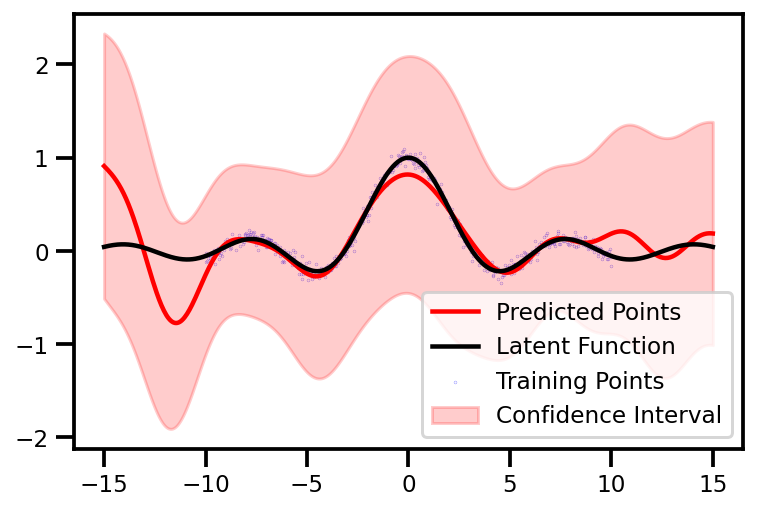

In [182]:
yhat = model(xtest)

plot_results(yhat.mean().numpy(), yhat.stddev().numpy())

## Deep Gaussian Processes (RFF)

Train on 1000 samples
Epoch 1/500
1000/1000 [==============================] - 2s 2ms/sample - loss: 36.8524
Epoch 2/500
1000/1000 [==============================] - 0s 141us/sample - loss: 29.8914
Epoch 3/500
1000/1000 [==============================] - 0s 135us/sample - loss: 28.3100
Epoch 4/500
1000/1000 [==============================] - 0s 132us/sample - loss: 27.5571
Epoch 5/500
1000/1000 [==============================] - 0s 137us/sample - loss: 27.0303
Epoch 6/500
1000/1000 [==============================] - 0s 150us/sample - loss: 25.3025
Epoch 7/500
1000/1000 [==============================] - 0s 127us/sample - loss: 25.1574
Epoch 8/500
1000/1000 [==============================] - 0s 132us/sample - loss: 29.5244
Epoch 9/500
1000/1000 [==============================] - 0s 137us/sample - loss: 23.2684
Epoch 10/500
1000/1000 [==============================] - 0s 136us/sample - loss: 27.7809
Epoch 11/500
1000/1000 [==============================] - 0s 143us/sample - loss: 27.6934

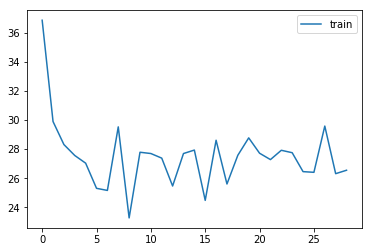

In [ ]:
# model parameters
lambda_ = 100.
noise = .5 #( 1 / lambda_) ** (1/2)  # weight std dev. prior
n_samples = xtrain.shape[0]


n_features = 60
trainable = True
# initialize model
model = tf.keras.Sequential([
    # RFF Layer
    RandomFourierFeatures(        
        output_dim=n_features,
#         kernel_initializer=tf.initializers.RandomNormal(),
        trainable=trainable,
        name='rff'
    ),
    # Variational Layer
    tfp.layers.DenseVariational(
        1 + 1,
        posterior_mean_field,
        prior_trainable,
#         kl_weight=1/n_samples,
    ),
    # Normal Distribution Output
    tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(
            loc=t[...,1:], 
            scale=1e-3 + tf.math.softplus(0.01 * t[..., 1:])
        )
    )
])

# do inference
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss = neg_log_likelihood


model.compile(
    optimizer=optimizer,
    loss=neg_log_likelihood
)

es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=20)

history = model.fit(xtrain, ytrain, epochs=500, verbose=1, callbacks=[es])

plot_loss(history)